In [1]:
# follow this:
# https://deepxde.readthedocs.io/en/latest/demos/pinn_inverse/lorenz.inverse.html

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import pytorch
import torch
import matplotlib.pyplot as plt

Using backend: pytorch



# Create synthetic data

In [3]:
alpha_real = 0.2
beta_real = 0.05
gamma_real = 0.01

total  [2.04643018e+05 1.47928048e+03 3.99489808e+06 7.98979617e+05]
total  5000000.000000002


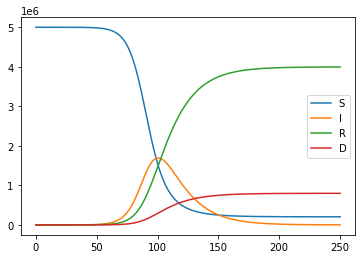

In [4]:
import ODE_SIR
solver = ODE_SIR.ODESolver()
t_synth, wsol_synth, N = solver.solve_SIRD(alpha_real, beta_real, gamma_real)
solver.plot_SIRD(t_synth, wsol_synth)

Use cell below if we want to subset timestep - ie simulate if we are at an early stage in the pandemic so have limited data

In [5]:
# keep this even if not subsetting
t = t_synth
wsol = wsol_synth

# subset
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

Note - we normalize by number of people here as it reduces the train time

In [6]:
S_sol, I_sol, R_sol, D_sol = wsol[:,0], wsol[:,1], wsol[:,2], wsol[:,3]
init_num_people = np.sum(wsol[0,:])
S_sol, I_sol, R_sol, D_sol = S_sol/init_num_people, I_sol/init_num_people, R_sol/init_num_people, D_sol/init_num_people

# PDE and data
Format the PDE and corresponding data (like IC and test points)

In [7]:
timedomain = dde.geometry.TimeDomain(0, max(t))

In [8]:
alpha = dde.Variable(0.1)
beta = dde.Variable(0.1)
gamma = dde.Variable(0.1)

In [9]:
def pde(t, y):
    S, I = y[:, 0:1], y[:, 1:2]
    
    dS_t = dde.grad.jacobian(y, t, i=0)
    dI_t = dde.grad.jacobian(y, t, i=1)
    dR_t = dde.grad.jacobian(y, t, i=2)
    dD_t = dde.grad.jacobian(y, t, i=3)
    
    return [dS_t + alpha*S*I, 
           dI_t - alpha*S*I + beta*I + gamma*I,
           dR_t - beta*I,
           dD_t - gamma*I]

In [10]:
def boundary(_, on_initial):
    return on_initial

# Initial conditions
ic_S = dde.icbc.IC(timedomain, lambda X: torch.tensor(S_sol[0]).reshape(1,1), boundary, component=0)
ic_I = dde.icbc.IC(timedomain, lambda X: torch.tensor(I_sol[0]).reshape(1,1), boundary, component=1)
ic_R = dde.icbc.IC(timedomain, lambda X: torch.tensor(R_sol[0]).reshape(1,1), boundary, component=2)
ic_D = dde.icbc.IC(timedomain, lambda X: torch.tensor(D_sol[0]).reshape(1,1), boundary, component=3)

In [11]:
# Test points
observe_S = dde.icbc.PointSetBC(t.reshape(len(t), 1), S_sol.reshape(len(S_sol), 1), component=0)
observe_I = dde.icbc.PointSetBC(t.reshape(len(t), 1), I_sol.reshape(len(I_sol), 1), component=1)
observe_R = dde.icbc.PointSetBC(t.reshape(len(t), 1), R_sol.reshape(len(R_sol), 1), component=2)
observe_D = dde.icbc.PointSetBC(t.reshape(len(t), 1), D_sol.reshape(len(D_sol), 1), component=3)

In [12]:
data = dde.data.PDE(
    timedomain,
    pde,
    [ic_S, ic_I, ic_R, ic_D, 
     observe_S, observe_I,
     observe_R,observe_D
     ],
    num_domain=50,
    num_boundary=10,
    anchors=t.reshape(len(t), 1),
)

# Set up model

In [13]:
layer_size = [1] + [32] * 4 + [4]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [14]:
model = dde.Model(data, net)
variables = [alpha, beta, gamma]
model.compile("adam", lr=0.01, #metrics=["l2 relative error"], 
              external_trainable_variables=variables)

Compiling model...
'compile' took 0.000285 s



# Train model

In [15]:
variable = dde.callbacks.VariableValue(variables, period=100)
losshistory, train_state = model.train(iterations=7500, callbacks=[variable])

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.13e-04, 9.22e-04, 6.38e-04, 1.54e-04, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 7.86e-01, 2.54e-02, 2.11e-01, 1.03e-01]    [1.13e-04, 9.22e-04, 6.38e-04, 1.54e-04, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 7.86e-01, 2.54e-02, 2.11e-01, 1.03e-01]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
100 [4.54e-03, -4.23e-03, -4.44e-03]
200 [4.17e-02, 7.41e-03, 3.72e-04]
300 [6.40e-02, 1.62e-02, 5.10e-03]
400 [9.89e-02, 2.53e-02, 4.46e-03]
500 [3.48e-02, 6.97e-03, 3.48e-03]
600 [3.64e-02, 3.90e-03, -1.81e-03]
700 [9.40e-02, 1.83e-02, 9.19e-03]
800 [1.04e-01, 1.89e-02, -6.99e-04]
900 [1.29e-01, 2.49e-02, 1.79e-03]
1000      [1.83e-05, 2.24e-06, 3.59e-06, 3.23e-06, 4.81e-05, 1.62e-05, 3.71e-06, 4.34e-06, 4.71e

# Show results

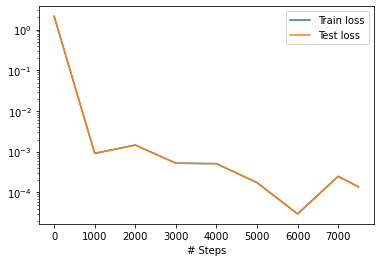

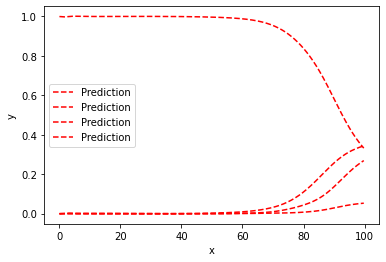

In [16]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

# Use parameters in ODE

Get alpha, beta and gamma from neural network and solve ODE using these parameters

In [17]:
alpha_nn, beta_nn, gamma_nn = variable.get_value()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')

Alpha: 0.17623166739940643, beta: 0.04154333099722862, gamma: 0.006792839150875807


In [18]:
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

Get best y prediction from neural network (code is copied from plot_best_state function in deepxde library)

In [19]:
y_dim = train_state.best_y.shape[1]

idx = np.argsort(train_state.X_test[:, 0])
t_nn_best = train_state.X_test[idx, 0]

wsol_nn_best = []
for i in range(y_dim):
    wsol_nn_best.append(train_state.best_y[idx, i]*init_num_people)
wsol_nn_best = np.array(wsol_nn_best).T

# Plot

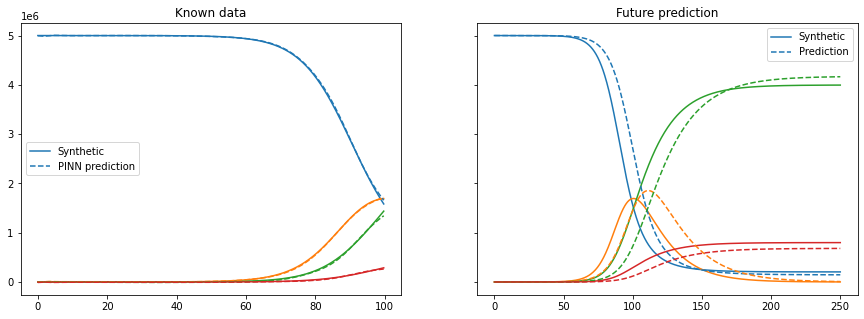

In [20]:
def set_color(line, colors):
    ''' Set color for each curve in a figure '''
    for idx, color in enumerate(colors):
        line[idx].set_color(color)
    
fig, axes = plt.subplots(1,2
                         #, sharex=True
                         , sharey=True
                         , figsize=(15,5))
colors = ['C0','C1','C2','C3']

### First ax
ax = axes[0]

ax.set_title('Known data')
line = ax.plot(t, wsol)
line[0].set_label('Synthetic')
set_color(line, colors)

line = ax.plot(t_nn_best, wsol_nn_best, linestyle='--')
line[0].set_label('PINN prediction')
set_color(line, colors)

ax.legend()

### Second ax
ax = axes[1]
ax.set_title('Future prediction')

line = ax.plot(t_synth, wsol_synth)
line[0].set_label('Synthetic')
set_color(line, colors)
line = ax.plot(t_nn_param, wsol_nn_param, linestyle='--')
set_color(line, colors)
line[0].set_label('Prediction')

ax.legend()